# Natural Language Processing

By: Felix Bachstein (Email: felix.bachstein@code.berlin , Slack: @bFelix)

-----
**Listening to long talks is a hobby for some people, but staying focused for extended amounts of time is often fatiguing and it is easy to miss details.  
Therefore, we want to use smartphones to recognize speech and find out how precise we can create a speech recognition algorithm. To achieve this, we use neural networks to filter out and process the single words out of audio streams.**

------

## Introduction

According to [this Medium article](https://medium.com/descript/which-automatic-transcription-service-is-the-most-accurate-2018-2e859b23ed19) Google currently achieves the highest transcription accuracy, with a Word-Error-Rate (short WER) of 16% - low enough to make sense of the transcript and high enough to annoy potential customers. Google in particular is focussing on the recognition of speech commands - that is, maximising the potential of their Google Voice Assistant, aiming on making it accurate and fast, as mentioned [here](https://www.wired.com/story/google-made-truly-usable-voice-assistant/), and so do other companies like Amazon or Microsoft.  
However, none of them really focus on actual *speech* recognition.
On the `transcription-gcloud` branch you can try out it's accuracy - it works, but isn't really satisfying to use.  
So, we asked ourselves, what makes it so hard?  
And how far can we come with an own algorithm adapted to be used on speeches?  
To answer these questions we started working on our own speech-to-text converter, using the open-source [Common Voice](https://voice.mozilla.org/en) data set crowdsourced by Mozilla.  


##### We want to create a tool that:
1. Takes a continuous audiostream with unknown length
2. Converts the contained speech into meaningful sentences
3. Gives back the sentences as sequential stream of single words

A server would handle the connection to the phone using grpc, a framework for rpc i.e. a real-time streaming protocol. However, since the focus lies on speech-reognition, I will ignore the where-from of the audio and concentrate on the processing.

## Getting started

#### Technical setup

To reproduce everything, please make sure that all the modules in `requirements.txt` are properly installed.  
In the best case, running the command below works (otherwise please install it manually, using the given command):

In [1]:
COMMAND = "pip install --user -r ../../requirements.txt"

from os import system
system(COMMAND)

0

### Process

#### The speech data:

The continous audio stream means our tool gets small chunks of audio data, a few hundred samples, as an array, at a time.
A first dive into the matter resulted in the following plan:

1. Extract features from one chunk of data, called window.
2. Feed these features into a neural network trained on the aforementioned data set; the result being single phonemes.
3. Put these phonemes back together to meaningful words

The feature extraction part is easy.
Using the python library `librosa` we calculated the mfcc on each of these windows, that is, the mel-frequency cepstral coefficients. These coefficients would then be our features.  
Internally, this would do a fourier transform (Split the sound into its frequencies) mapped onto a mel-scale plus some further processing. 

I will visualise this process on two separate audio files found in this folder, randomly taken out of the data set:  
* **File a:**
  * Name:
    *  77c44851bac797d08b5724fcd0412c0a073f7888adc34a5ab588669e08319729647c4bc28e10a4b0609a7cdd15016f91e5a945314fab8392e4225df53744e51f.mp3
  * Sentence:
    * "One of the first problems you'll run into is recognition errors, particularly with any command that allows raw dictation."
* **File b:**
  * Name:
    * 897cde9ed3b2abb15d79a11aca4965eae80b2b42604797e9bb477ebfd93ca29a5a1fddea18f315746aea497c06a3f3fe5daf3f100ba1b35dc22b0800d3e93ee2.mp3
  * Sentence:
    * "It was only when I got this close to it that the strangeness of it was at all evident to me."


In [30]:
from transcription import visualise

In [31]:
# Create a new visualiser which loads the given file and looks up its data in the tsv file (optional):
PATH_A = "77c44851bac797d08b5724fcd0412c0a073f7888adc34a5ab588669e08319729647c4bc28e10a4b0609a7cdd15016f91e5a945314fab8392e4225df53744e51f.mp3"
PATH_B = "897cde9ed3b2abb15d79a11aca4965eae80b2b42604797e9bb477ebfd93ca29a5a1fddea18f315746aea497c06a3f3fe5daf3f100ba1b35dc22b0800d3e93ee2.mp3"
PATH_TSV = "validated.tsv"

a = visualise.Visualise(PATH_A, tsv=PATH_TSV)
b = visualise.Visualise(PATH_B, tsv=PATH_TSV)

From the object we can look at the audio data and it's sample rate:

In [28]:
# Sample rate in Hertz  (samples per second):
sra = a.sample_rate
srb = b.sample_rate

print("Sample rate of a: " + str(sra))
print("Sample rate of b: " + str(srb))

Sample rate of a: 22050
Sample rate of b: 22050


As well as it's metadata:

In [7]:
a.metadata

,client_id,path,sentence,up_votes,down_votes,age,gender,accent
0,1f316ddca02594b5010fdecbe8c071bccbd29375500b13161ca26afe4737fa013101d69cb09eff35293238e7b14075018231b70abdba72fec1c3a4adbd7efaab,77c44851bac797d08b5724fcd0412c0a073f7888adc34a5ab588669e08319729647c4bc28e10a4b0609a7cdd15016f91e5a945314fab8392e4225df53744e51f,"One of the first problems you'll run into is recognition errors, particularly with any command that allows raw dictation.",2,0,NaN,NaN,NaN


In [8]:
b.metadata

,client_id,path,sentence,up_votes,down_votes,age,gender,accent
1,02b8c45390d1d84916129e7b00a934f4f46dae79e0520303b6a2efc5753d7b78d701b635696fe69fdc0a06db05bb7cf770b6caed34d23bcc79a3db91f65e9db5,897cde9ed3b2abb15d79a11aca4965eae80b2b42604797e9bb477ebfd93ca29a5a1fddea18f315746aea497c06a3f3fe5daf3f100ba1b35dc22b0800d3e93ee2,It was only when I got this close to it that the strangeness of it was at all evident to me.,6,2,NaN,NaN,NaN


In [9]:
# Show 20 samples of both files, starting at the fifth second:
print(a.data[(5*sra) : (5*sra + 20)])
print(b.data[(5*srb) : (5*srb + 20)])

[-0.01885764 -0.0272058  -0.0357662  -0.04296669 -0.04838737 -0.04560987
 -0.0375044  -0.02255747 -0.00750283  0.00444547  0.01054961  0.00404552
 -0.02160558 -0.06494284 -0.11601822 -0.15945661 -0.18460864 -0.18714596
 -0.16486757 -0.11757588]
[ 2.1603631e-03  2.2066075e-03  1.4661019e-03  3.7205135e-04
 -3.1545336e-04 -3.6209519e-04  2.5941423e-05  4.2362564e-04
  5.5621500e-04  3.4448589e-04  5.5802175e-05 -3.7329883e-04
 -6.6656905e-04 -8.0206571e-04 -7.3168927e-04 -3.8592148e-04
 -1.3345815e-04  1.3516589e-04  1.8176911e-04  1.2622373e-04]


Also, we can listen to it (The command is non-blocking, so please don't run them in quick succession):

In [25]:
a.play()

In [13]:
#b.play() # turn up the volume

This already shows one of the issues:
Differences in sound quality and amplitude. If we take a look at the plotted data, this becomes more clear:

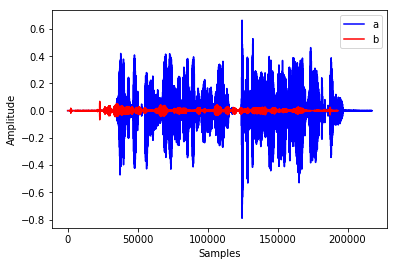

In [14]:
# Plot the samples of both audio files
import matplotlib.pyplot as plt

plt.plot(a.data, 'b', label='a')
plt.plot(b.data, 'r', label='b')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()

So we try to transform it to something more meaningful. Here the spectogram:

/home/felix/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


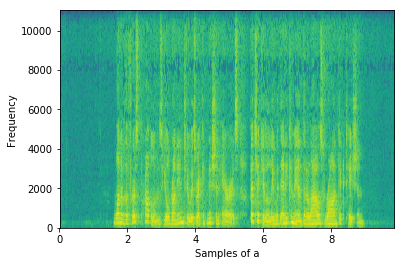

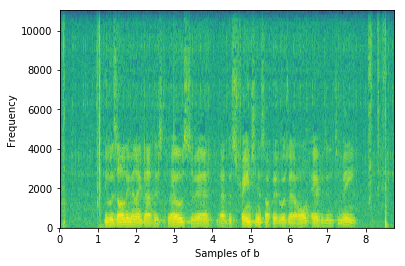

In [16]:
visualise.specgram(a, xlabel="Samples of a", ylabel="Frequency")
visualise.specgram(b, xlabel="Samples of b", ylabel="Frequency")

The spectograms already look more similar, and show now seperated yellow colored blobs representing phonemes and words.

But let's transform this one more time, to the above mentioned mel-frequency cepstrum, plotting the coefficients of it:
(The code for this is taken from the librosa website)

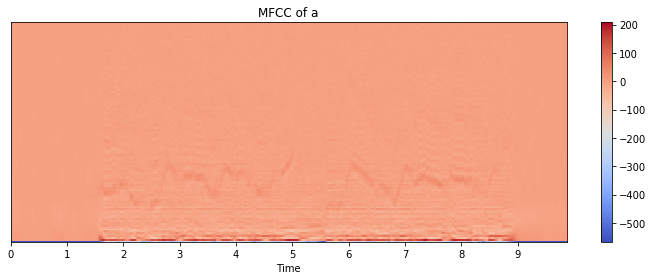

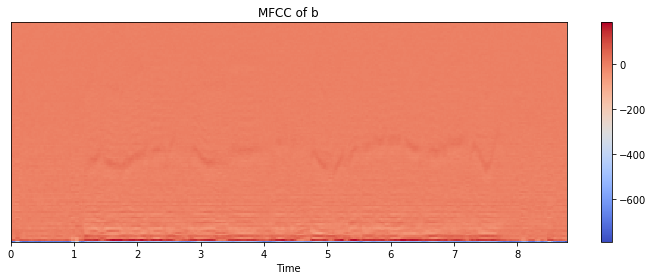

In [24]:
from librosa.feature import mfcc
from librosa.display import specshow

# Amount of samples per window, arbitrarily chosen:
CHUNK = 320

# Type of the discrete cousine transform used to calculate the mel-frequency cepstrum:
DCT_TYPE = 2  # Type 2 appears the most useful for phoneme recognition

# Amount of windows per file:
windows_a = int(len(a.data) / CHUNK)
windows_b = int(len(b.data) / CHUNK)

mfccs_a = mfcc(a.data, a.sample_rate, n_mfcc=windows_a, dct_type=DCT_TYPE)
mfccs_b = mfcc(b.data, b.sample_rate, n_mfcc=windows_b, dct_type=DCT_TYPE)

# Plot a:
plt.figure(figsize=(10, 4))
specshow(mfccs_a, x_axis='time')
plt.colorbar()
plt.title('MFCC of a')
plt.tight_layout()

# Plot b:
plt.figure(figsize=(10, 4))
specshow(mfccs_b, x_axis='time')
plt.colorbar()
plt.title('MFCC of b')
plt.tight_layout()

The written data:
So these are examples of the audio files we have.  
let's have a look at its labels, the written sentences:

In [20]:
print(a.metadata["sentence"])
print(b.metadata["sentence"])

0    One of the first problems you'll run into is recognition errors, particularly with any command that allows raw dictation.
Name: sentence, dtype: object
1    It was only when I got this close to it that the strangeness of it was at all evident to me.
Name: sentence, dtype: object


Using nltk's tokenizer and the CMU dictionary, we can easily get the phonetic spelling of this sentence:

In [21]:
phonemes_a = [phonem for phonem in a.phonemes()]
phonemes_b = [phonem for phonem in b.phonemes()]

['One', 'of', 'the', 'first', 'problems', "you'll", 'run', 'into', 'is', 'recognition', 'errors,', 'particularly', 'with', 'any', 'command', 'that', 'allows', 'raw', 'dictation.', '0', '1']
zero
one
['It', 'was', 'only', 'when', 'I', 'got', 'this', 'close', 'to', 'it', 'that', 'the', 'strangeness', 'of', 'it', 'was', 'at', 'all', 'evident', 'to', 'me.', '1', '1']
one
one


As we see, the amount of phonemes of both files is similar, just as the length of the part of the audio containing spoken parts (Showing that phonemes in average are about equally long, though this does not have to be the case):

In [22]:
print("Phonemes of file a: " + str(len(phonemes_a)))
print("Phonemes of file b: " + str(len(phonemes_b)))

Phonemes of file a: 26
Phonemes of file b: 27


### Putting it together

So, we have our data set consisting of around 500.000 short labeled audio clips.  
To use them for speech recognition, we need to do some machine learning, as trivial algorithms don't really work on something as complex as language.

##### Neural Networks

What exactly do we want?  
In the end, we want to have some kind of black box were audio goes in and recognized words come out.  
A neural network ist well suited for this task; if we feed it all the data we have to train it, it should be able to recognize speech pretty accurate.  Plus, we could make use of recurrent neural networks so for every instance to be recognized, the system knows a few preceding instances. That'd make it great at recognizing combinatinos of phonemes or words frequently appearing in the language being used.  

So, how to train it?  
We could try to train it on words, but given the amount of words in the english language, for example, our neural network would need to be very big. [Ocford Dictionaries](https://en.oxforddictionaries.com/explore/how-many-words-are-there-in-the-english-language/) guesses around one to three quarter of words, depending on whether to include technical terms and foreign word inflections as well.  
This is where we come back at the phonemes: with around 40 phonemes, we can use a rather small network.  

We start with one with one input neuron per mel-frequency cepstral coefficient and one output neuron per phoneme.
Also, we might want one or two layers to reduce the mfcc features down to the ~40 phonemes.

Now, to the training. We have our written sentence splitted already, now we only need to split the spoken data - which turns out to be the biggest issue in this project.  
What we want is one spoken phoneme per written phoneme, so we can always give the mfcc of one spoken phoneme to the network and tell it what it is in spelled form. Then, for using it, we can split our audio stream using the same algorithm, and it will give us out the correct phoneme.
The problem is, that there is no easy deterministic way to figure out where phonemes start and where they end - In the end, we will need to look at the mfccs, look at how they change for different phonemes and, in the best case, train a classifier on it.  
I mean, two machine learning algorithms are better than one.

So let's assume we are able to split audio streams into single phonemes. As mentioned we send this stream into the neural network and, after some fine tuning of the parameters, get accurate phonemes.  
What's then left is putting phonemes together, which is a more easy task. Thanks to libraries like nltk, we can use context-free grammar and hidden markov models to assemble the phonemes back to word.

##### Markov Chains

The Hidden Markov Model, HMM, suggests that, just as we use recurrent neural networks for common sequences of phonemes, words also tend to follow specific other words.
This is especially useful in chosing the right words for given contexts; e.g. if we take a sequence like `The sun is ...` we rather expect `shining` to follow, and not, like, `whining`.

##### Context-free Grammar

Context-free Grammar Models, CGM, in parallel, suggest that sentences usually follow a specific grammatical pattern, leading to beautiful tree graphs showing a language model, e.g. [this one](https://browse.startpage.com/do/show_picture.pl?l=english&rais=1&oiu=https%3A%2F%2Fcdn-images-1.medium.com%2Fmax%2F800%2F1*JT4n7Xeo4A5hrR0Q01Wk4A.png&sp=783fec81ace8b084b13ee8d746b492e7&t=default) taken from kdnuggets.com.  


In the end, we can try to use the context-free grammar model to do a rough filtering to get the result grammatically correct (While taking fillwords like "uhm" or "like" into account) and apply a markov chain with a length of two to three to it.  
This could also be improved on by using a second neural network; this one'd just need to be trained on a lot of english texts which you can easily find using web scrapers or collections of literatur.

----
### Conclusion

So, at our current state, we still have some way to go for our own speech recognition system but it seems a lot more feasible than it looked like at the beginning.  
But whether or not it works in the end, it will surely not be very good; in the end, even companies like Google who invest billions of money and a lot of resources on this only came so far.
But over the years, it will become better, and, maybe in a few years or decades, speech assistants will already be good enough to not get annoyed by them.

----

### References

* Marjias Workshop about Natural Language Processing
* https://realpython.com/python-speech-recognition/
* https://www.isca-speech.org/archive/interspeech_2015/papers/i15_1478.pdf
* https://www.svds.com/tensorflow-rnn-tutorial/
+ A few articles I've read about the topic
  * e.g. https://www.wired.com/story/google-made-truly-usable-voice-assistant/
+ A few blogs, including Google's about their current research project
  * e.g. https://ai.googleblog.com/2019/03/an-all-neural-on-device-speech.html